In [17]:
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

#model = fasttext.train_supervised(input="data/103_classes_filtered.csv", lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')

fastText pre-processed data

In [18]:
X_train = "../data/fasttext_format_train_filtered.csv"
X_test = "../data/fasttext_format_test_filtered.csv"
X_val = "../data/fasttext_format_val_filtered.csv"


Training 3 models with different hyperparameters

In [19]:
model_1 = fasttext.train_supervised(input=X_train, lr=0.5, epoch=20, wordNgrams=2, bucket=200000, dim=50, loss='ova')

Read 3M words
Number of words:  393627
Number of labels: 103
Progress: 100.0% words/sec/thread:  774040 lr:  0.000000 avg.loss: 35.419624 ETA:   0h 0m 0s


In [20]:
model_2 = fasttext.train_supervised(input=X_train, lr=0.4, epoch=30, wordNgrams=2, bucket=200000, dim=50, loss='ova')

Read 3M words
Number of words:  393627
Number of labels: 103
Progress: 100.0% words/sec/thread:  708250 lr:  0.000000 avg.loss:  4.923187 ETA:   0h 0m 0s 47.0% words/sec/thread:  712538 lr:  0.211969 avg.loss:  8.049754 ETA:   0h 0m 9s


In [21]:
model_3 = fasttext.train_supervised(input=X_train, lr=0.5, epoch=20, wordNgrams=4, bucket=200000, dim=50, loss='ova')

Read 3M words
Number of words:  393627
Number of labels: 103
Progress: 100.0% words/sec/thread:  696153 lr:  0.000000 avg.loss: 35.285130 ETA:   0h 0m 0s


Saving models for future

In [22]:
model_1.save_model("../models/model_1_fasttext.bin")
model_2.save_model("../models/model_2_fasttext.bin")
model_3.save_model("../models/model_3_fasttext.bin")


Transforming data for train and validation set

In [23]:
df_val = pd.read_csv(X_val, sep='\t')
val_list = df_val['0'].to_list()
y_val_list= df_val['1'].to_list()
y_val_final = []
for i in y_val_list:
    y_val_final.append(i.split(' '))
mlb_test =  MultiLabelBinarizer()
y_val_final = mlb_test.fit_transform(y_val_final)
classes_li = mlb_test.classes_

In [24]:
df_tr = pd.read_csv(X_train, sep='\t')
tr_list = df_tr['0'].to_list()
y_tr_list= df_tr['1'].to_list()
y_tr_final = []
for i in y_tr_list:
    y_tr_final.append(i.split(' '))
y_tr_final = mlb_test.transform(y_tr_final)
classes_li = mlb_test.classes_

In [25]:
def get_predictions(val_list, model):
    y_pred = []
    for i in val_list:
        y_i = model.predict(i.replace("\n", ""), k=-1, threshold=0.7)
        y_pred.append(y_i)
    return y_pred

Cleaning predictions for better interpretation

In [26]:
def clean_pred(pred):
    pred_li = []
    for i in range(0,len(pred)):
        pred_li.append(list(pred[i][0]))
    pred_li_b = mlb_test.transform(pred_li)    
    return pred_li_b

In [27]:
y_pred1 = get_predictions(val_list, model_1)
y_pred2 = get_predictions(val_list, model_2)
y_pred3 = get_predictions(val_list, model_3)

y_pred1_tr = get_predictions(tr_list, model_1)
y_pred2_tr = get_predictions(tr_list, model_2)
y_pred3_tr = get_predictions(tr_list, model_3)

y_pred1_li = clean_pred(y_pred1)
y_pred2_li = clean_pred(y_pred2)
y_pred3_li = clean_pred(y_pred3)

y_pred1_li_tr = clean_pred(y_pred1_tr)
y_pred2_li_tr = clean_pred(y_pred2_tr)
y_pred3_li_tr = clean_pred(y_pred3_tr)

Evaluation metrics calculation

In [28]:
def get_metrics(y_pred, y_true, classes):
    cm = {}
    accuracy = []
    f1 = []
    for i in range(len(classes)):
        #print(classes[i])
        cm[classes[i]] = confusion_matrix(y_pred=y_pred[:,i], y_true=y_true[:,i])
        accuracy.append(accuracy_score(y_pred=y_pred[:,i], y_true=y_true[:,i]))
        f1.append(f1_score(y_pred=y_pred[:,i], y_true=y_true[:,i]))
    return cm ,accuracy, f1 

In [29]:
cm1, v_accuracy1, f1_1 = get_metrics(y_pred1_li, y_val_final, classes_li)
cm2, v_accuracy2, f1_2 = get_metrics(y_pred2_li, y_val_final, classes_li)
cm3, v_accuracy3, f1_3 = get_metrics(y_pred3_li, y_val_final, classes_li)

cm1_tr, v_accuracy1_tr, f1_1_tr = get_metrics(y_pred1_li_tr, y_tr_final, classes_li)
cm2_tr, v_accuracy2_tr, f1_2_tr = get_metrics(y_pred2_li_tr, y_tr_final, classes_li)
cm3_tr, v_accuracy3_tr, f1_3_tr = get_metrics(y_pred3_li_tr, y_tr_final, classes_li)


Plot for train / val accuracy

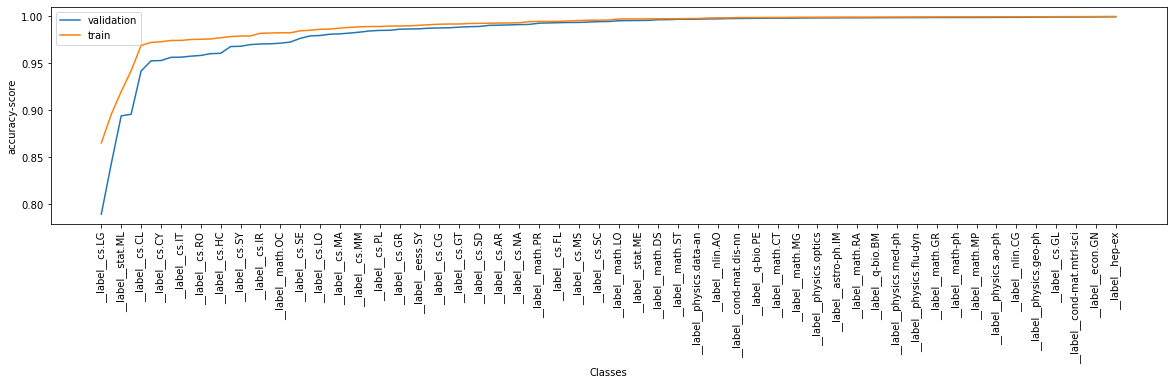

In [30]:
plt.close("all")
fig, ax = plt.subplots(figsize = (20, 4))
new_tags = classes_li[np.argsort(v_accuracy3_tr)]
idx = np.arange(len(classes_li))
width = 0.5
ax.plot(sorted(v_accuracy3))
ax.plot(sorted(v_accuracy3_tr))

xticks_idx = idx[::2]

ax.set_xticks(xticks_idx)
ax.set_xticklabels([new_tags[x] for x in xticks_idx], rotation=90)
ax.set_ylabel("accuracy-score")
ax.set_xlabel("Classes")
ax.legend(['validation', 'train'])
#plt.yscale("log")
plt.show()
fig.savefig("fasttext_acc_plot.pdf", bbox_inches="tight")

Mean score for each model

In [31]:
print("mean f1 score for model 1: ", np.mean(f1_1_tr))
print("mean f1 score for model 2: ", np.mean(f1_2_tr))
print("mean f1 score for model 3: ", np.mean(f1_3_tr))
print("mean accuracy for model 1: ", np.mean(v_accuracy1_tr))
print("mean accuracy for model 2: ", np.mean(v_accuracy2_tr))
print("mean accuracy for model 3: ", np.mean(v_accuracy3_tr))


mean f1 score for model 1:  0.30993867968226085
mean f1 score for model 2:  0.42922964747221765
mean f1 score for model 3:  0.2939429471115569
mean accuracy for model 1:  0.9899710718339629
mean accuracy for model 2:  0.9917407006967434
mean accuracy for model 3:  0.9892664836446751


Getting results on the test set

In [32]:
df_test = pd.read_csv(X_test, sep='\t')
test_list = df_test['0'].to_list()
y_test_list= df_test['1'].to_list()
y_test_final = []
for i in y_test_list:
    y_test_final.append(i.split(' '))
y_test_final = mlb_test.transform(y_test_final)

In [33]:
y_pred_test = get_predictions(test_list, model_3)
y_pred_test_clean = clean_pred(y_pred_test)
cm_test, accuracy_test, f1_test = get_metrics(y_pred_test_clean, y_test_final, classes_li)


In [34]:
print("mean f1 score for model 3, on test data: ", np.mean(f1_test))
print("mean accuracy for model 3, on test data: ", np.mean(accuracy_test))


mean f1 score for model 3, on test data:  0.1377935223655156
mean accuracy for model 3, on test data:  0.983559695940959


In [35]:
print("Minimum accuracy score on test: ", min(accuracy_test), " for class ", classes_li[np.argmin(accuracy_test)])
print("Maximum accuracy score on test: ", max(accuracy_test), " for class ", classes_li[np.argmax(accuracy_test)])


Minimum accuracy score on test:  0.7893558229986511  for class  __label__cs.LG
Maximum accuracy score on test:  0.9994106939406241  for class  __label__cond-mat.mtrl-sci


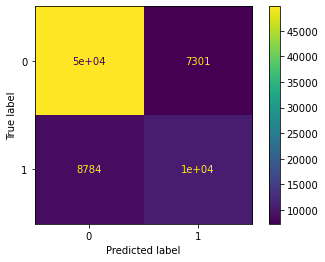

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm_test[classes_li[26]]).plot()
# 26 is the index of class cs_lG that has maximum frequency in the dataset